In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from all_functions import refactorGiniWorldBankDf


In [2]:
revenuMondial = pd.read_csv("../data/data-projet7.csv", parse_dates=True)
revenuMondial.head(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


In [3]:
# Ci-dessus, les revenues mondiale pour une période donnée

In [4]:
# Premère étape. Identifiquation des pays

In [5]:
countryCodes = pd.read_csv("../data/iso.csv", parse_dates=True)
countryCodes.head(5)

,name,iso
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Andorra,AND
4,Angola,AGO


In [6]:
merged_df = pd.merge(revenuMondial, countryCodes, left_on='country', right_on='iso', how='left')
incomes = merged_df[['name','country', 'year_survey', 'quantile','nb_quantiles','income','gdpppp']]
incomes = incomes.rename(columns={"name":"nation"})
incomes = incomes.rename(columns={"year_survey":"year"})
incomes.replace(',', '.', regex=True, inplace=True)
incomes['income'] = incomes['income'].astype(float)
incomes['gdpppp'] = incomes['gdpppp'].astype(float)
incomes['year'] = incomes['year'].astype(int)
incomes.head(5)

,nation,country,year,quantile,nb_quantiles,income,gdpppp
0,Albania,ALB,2008,1,100,728.89795,7297.0
1,Albania,ALB,2008,2,100,916.66235,7297.0
2,Albania,ALB,2008,3,100,1010.91600,7297.0
3,Albania,ALB,2008,4,100,1086.90780,7297.0
4,Albania,ALB,2008,5,100,1132.69970,7297.0


In [7]:
# Information dataFrame

In [8]:
incomes["year"] = incomes["year"].astype(int)

# Résumé des dates minimales et maximales
date_min = incomes['year'].min()
date_max = incomes['year'].max()
# Résumé des revenus minimales et maximales
incomeMin = incomes['income'].min()
incomeMax = incomes['income'].max()
rowMinIncome = incomes.loc[incomes['income'] == incomeMin]
rowMaxIncome = incomes.loc[incomes['income'] == incomeMax]
# Récupérer le pays associé aux revenus minimaux et maximaux
countryMinIncome = rowMinIncome['nation'].values[0]  # Prendre la première valeur car il pourrait y avoir plusieurs lignes
countryMaxIncome = rowMaxIncome['nation'].values[0]
# Affichage des résultats
print(f"Pays avec le revenu minimal : {countryMinIncome} {incomeMin}")
print(f"Pays avec le revenu maximal : {countryMaxIncome} {incomeMax}")
# Affichage des résultats
print(f"Date minimale : {date_min}")
print(f"Date maximale : {date_max}")

Pays avec le revenu minimal : China 16.719418
Pays avec le revenu maximal : United States 176928.55
Date minimale : 2004
Date maximale : 2011


In [9]:
arrIncomesYears = incomes['year'].sort_values(ascending=True).unique()
arrIncomesYears = [str(value) for value in arrIncomesYears]
arrIncomesYears

['2004', '2006', '2007', '2008', '2009', '2010', '2011']

In [10]:
nombrePays = incomes['country'].nunique()
print(f"Nombre de pays par année: {nombrePays}")

Nombre de pays par année: 116


Traitement des donnée manquante

In [11]:
# Grouper par pays
groupedByCountry = incomes.groupby('country')
# Liste des quantiles attendus (1 à 100)
expectedQuantiles = set(range(1, 101))
# Créer une liste pour stocker les pays avec des quantiles manquants
countriesWithMissingQuantiles = []

# Parcourir chaque groupe (pays) et vérifier les quantiles manquants
for country, group in groupedByCountry:
    actualQuantiles = set(group['quantile'])
    missingQuantiles = expectedQuantiles - actualQuantiles
    
    if missingQuantiles:
        countriesWithMissingQuantiles.append((country, missingQuantiles))

# Afficher les résultats
if countriesWithMissingQuantiles:
    print("Pays avec des quantiles manquants :")
    for country, missingQuantiles in countriesWithMissingQuantiles:
        print(f"{country}: Quantiles manquants {missingQuantiles}")
else:
    print("Aucun pays avec des quantiles manquants.")

Pays avec des quantiles manquants :
LTU: Quantiles manquants {41}


In [12]:
ltu = 'LTU'
moyenneLTUIncome = incomes.loc[(incomes['country'] == ltu) & (incomes['quantile'] == 40) 
            | (incomes['country'] == ltu) & (incomes['quantile'] == 42)]['income'].mean();
moyenneLTUIncome

4882.14065

In [13]:
dfMissingRowLTU = pd.DataFrame({'nation':'Lithuania','country': [ltu], 'year': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [moyenneLTUIncome], 'gdpppp': 17571.0});

dfMissingRowLTU

,nation,country,year,quantile,nb_quantiles,income,gdpppp
0,Lithuania,LTU,2008,41,100,4882.14065,17571.0


In [14]:
incomes = pd.concat([incomes, dfMissingRowLTU], ignore_index=True, sort=True)
display(incomes.shape)
incomes.head()

(11700, 7)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
0,ALB,7297.0,728.89795,Albania,100,1,2008
1,ALB,7297.0,916.66235,Albania,100,2,2008
2,ALB,7297.0,1010.91600,Albania,100,3,2008
3,ALB,7297.0,1086.90780,Albania,100,4,2008
4,ALB,7297.0,1132.69970,Albania,100,5,2008


In [15]:
incomes[incomes['country'] == 'LTU'].head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
6200,LTU,17571.0,566.3453,Lithuania,100,1,2008


In [16]:
countriesNullsdpppp = incomes.loc[incomes['gdpppp'].isnull(), 'country'].unique()
countriesNullsdpppp

array(['XKX', 'PSE'], dtype=object)

In [17]:
xkx = countriesNullsdpppp[0];
pse = countriesNullsdpppp[1];

Je récupére le dataset de la worlbank afin de récuperer les gd pppp 


In [18]:
gdpppp = pd.read_csv("../data/worldbank-gdpppp.csv", parse_dates=True, sep=';')
gdpppp = gdpppp.iloc[: , :-1]
copyGd = gdpppp.copy
gdpppp.head(1)

,Country Name,Country Code,Indicator Name,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP per capita (constant LCU),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47461.615474,46386.672241,45804.246592,46317.795605,49316.830489,50242.212175,48863.866312,37095.214575,47369.425924,52368.693789


In [19]:
pseGd = gdpppp[gdpppp['Country Code'] == pse]
pseGdppp = pseGd['2009'].values[0]
pseGdppp

2840.01594969395

In [20]:
getXKXGd = gdpppp[gdpppp['Country Code'] == xkx]
xkxGdppp = getXKXGd['2009'].values[0]
xkxGdppp

2109.4339172761

In [21]:
incomes.loc[incomes['country'] == xkx, 'gdpppp'] = xkxGdppp
incomes.loc[incomes['country'] == xkx, 'nation'] = 'Kosovo'
incomes.loc[incomes['country'] == pse, 'gdpppp'] = pseGdppp
incomes.loc[incomes['country'] == pse, 'nation'] = 'Palestine'
incomes[incomes['country'] == xkx].head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
5800,XKX,2109.433917,437.8937,Kosovo,100,1,2008


In [22]:
incomes[incomes['country'] == pse].head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
11299,PSE,2840.01595,195.2899,Palestine,100,1,2009


#Indice de gini 

In [23]:
giniPath = "../data/gini.csv"
# Nettoyage de base des données.
giniWorld = pd.read_csv(giniPath, delimiter=',', parse_dates=True)
giniWorld = giniWorld.drop('Indicator Name', axis=1)
giniWorld = giniWorld.drop('Indicator Code', axis=1)
giniWorld = giniWorld.dropna(axis=1, how='all')
giniWorld = giniWorld.rename(columns={"Country Code":"CountryCode"})
giniWorld = giniWorld.rename(columns={"Country Name":"Country"})
giniWorld = giniWorld.dropna(how='all')
giniWorld = giniWorld.dropna(axis=1, how='all')
giniWorld

,Country,CountryCode,1979,1980,1981,1982,1983,1984,1985,1986,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0
260,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN
261,South Africa,ZAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN
262,Zambia,ZMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,55.6,NaN,NaN,NaN,NaN,57.1,NaN,NaN


In [24]:
# pays depuis iso si il existe pas dans le df gini
missGiniIso = ~np.isin(countryCodes['iso'].values, giniWorld.CountryCode.values)
countryCodes.loc[missGiniIso,['iso', 'name']]

,iso,name
170,TWN,Taiwan
190,VAT,Vatican City


In [25]:
new_row = pd.DataFrame({'Country': ['Taiwan'], 'CountryCode': ['TWN']})
new_row.loc[:, '1979':'2017'] = float('nan')
giniWorld = pd.concat([giniWorld, new_row], ignore_index=True)
giniWorld.loc[giniWorld['CountryCode'] == 'TWN', 1995] = 31.8
giniWorld.loc[giniWorld['CountryCode'] == 'TWN', 2005] = 34
giniWorld.loc[giniWorld['CountryCode'] == 'TWN', 2010] = 34.1
giniWorld.head()

,Country,CountryCode,1979,1980,1981,1982,1983,1984,1985,1986,...,2011,2012,2013,2014,2015,2016,2017,1995,2005,2010
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Verification si nous avons des données d'indice de gini comparer au df gini
giniColumns = []
for value in giniWorld.columns:
    giniColumns.append(value)
    
giniVars = [year for year in giniColumns if year in (arrIncomesYears)]
giniMelt = pd.melt(giniWorld, id_vars =['CountryCode', 'Country'], value_vars = giniColumns, var_name ='year', 
                    value_name ='gini')
# La lecture d'un indice de gini se fait entre 0 et 1
giniMelt['gini'] = round(giniMelt['gini']/100, 2)
giniMelt.dropna(inplace=True)
giniMelt['year'] = giniMelt['year'].astype(int)
giniMelt = giniMelt.rename(columns={"CountryCode":"country"})
giniMelt = giniMelt.rename(columns={"Country":"nation"})
giniMelt.head(100)

,country,nation,year,gini
113,ISR,Israel,1979,0.36
183,PAN,Panama,1979,0.49
249,USA,United States,1979,0.35
272,ARG,Argentina,1980,0.41
414,MDG,Madagascar,1980,0.47
...,...,...,...,...
3146,THA,Thailand,1990,0.45
3156,TUN,Tunisia,1990,0.40
3187,ARG,Argentina,1991,0.47
3198,BGD,Bangladesh,1991,0.28


In [27]:
# On insere les donnees dans les rev

In [28]:
incomesGini = pd.merge(incomes, giniMelt, how='left', on=['country', 'country', 'year'])
incomes = incomesGini
if 'nation_y' in incomes:
    incomes = incomes.drop('nation_y' , axis=1)
if 'nation_x' in incomes:
    incomes = incomes.rename(columns={"nation_x":"nation"})
if 'gini_y' in incomes:
    incomes = incomes.drop('gini_y' , axis=1)
    incomes = incomes.rename(columns={"gini_x":"gini"})
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3


In [29]:
# Donnee manquante gini dans notre df de base 
countryGiniMissed = incomes[incomes['gini'].isna()]
countryGiniMissed['country'].unique()

array(['AZE', 'CAN', 'CHN', 'EGY', 'GHA', 'GTM', 'HRV', 'IND', 'IRN',
       'IRQ', 'ISR', 'KEN', 'KHM', 'XKX', 'LKA', 'MAR', 'MKD', 'MLI',
       'MYS', 'NGA', 'PAK', 'SRB', 'TWN', 'USA', 'YEM', 'COD'],
      dtype=object)

In [30]:
incomes[incomes['country'] == 'YEM'].head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
11399,YEM,2224.0,162.95131,Yemen,100,1,2008,NaN
11400,YEM,2224.0,241.20471,Yemen,100,2,2008,NaN
11401,YEM,2224.0,274.72772,Yemen,100,3,2008,NaN
11402,YEM,2224.0,299.72230,Yemen,100,4,2008,NaN
11403,YEM,2224.0,319.84152,Yemen,100,5,2008,NaN


In [32]:
#https://fr.countryeconomy.com/demographie/indice-gini/cambodge
incomes.loc[incomes['country'] == 'AZE', 'gini'] = 0.33
incomes.loc[incomes['country'] == 'CAN', 'gini'] = 0.31
incomes.loc[incomes['country'] == 'CHN', 'gini'] = 0.41
incomes.loc[incomes['country'] == 'EGY', 'gini'] = 0.28
incomes.loc[incomes['country'] == 'GHA', 'gini'] = 0.43
incomes.loc[incomes['country'] == 'KHM', 'gini'] = 0.31
incomes.loc[incomes['country'] == 'GTM', 'gini'] = 0.4
incomes.loc[incomes['country'] == 'HRV', 'gini'] = 0.28
incomes.loc[incomes['country'] == 'IND', 'gini'] = 0.34
incomes.loc[incomes['country'] == 'IRN', 'gini'] = 0.4
incomes.loc[incomes['country'] == 'IRQ', 'gini'] = 0.29
incomes.loc[incomes['country'] == 'ISR', 'gini'] = 0.38
incomes.loc[incomes['country'] == 'KEN', 'gini'] = 0.38
incomes.loc[incomes['country'] == 'XKX', 'gini'] = 0.27
incomes.loc[incomes['country'] == 'LKA', 'gini'] = 0.37
incomes.loc[incomes['country'] == 'MAR', 'gini'] = 0.39
incomes.loc[incomes['country'] == 'MKD', 'gini'] = 0.31
incomes.loc[incomes['country'] == 'MLI', 'gini'] = 0.36
incomes.loc[incomes['country'] == 'MYS', 'gini'] = 0.41
incomes.loc[incomes['country'] == 'NGA', 'gini'] = 0.35
incomes.loc[incomes['country'] == 'PAK', 'gini'] = 0.29
incomes.loc[incomes['country'] == 'SRB', 'gini'] = 0.32
incomes.loc[incomes['country'] == 'TWN', 'gini'] = 0.34
incomes.loc[incomes['country'] == 'USA', 'gini'] = 0.4
incomes.loc[incomes['country'] == 'YEM', 'gini'] = 0.36
incomes.loc[incomes['country'] == 'COD', 'gini'] = 0.42
incomes = incomes[~incomes['nation'].isin(['North Macedonia'])]
incomes = incomes.reset_index(drop=True)
incomes[incomes['gini'].isna()]

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini


In [33]:
worldPopulation = pd.read_csv("../data/FAOSTAT_data_en_2-18-2024.csv", parse_dates=True)
worldPopulation = worldPopulation.loc[:, ['Area', 'Year', 'Value']]
worldPopulation['Value'] = worldPopulation['Value'] * 1000
worldPopulation['Value'] = worldPopulation['Value'].astype(int)
worldPopulation = worldPopulation.dropna(axis=1, how='all')
worldPopulation = worldPopulation.rename(columns={"Value":"population"})
pop2008 = worldPopulation[worldPopulation['Year'] == 2008]
pop2008

,Area,Year,population
58,Afghanistan,2008,26427199
130,Albania,2008,2951689
202,Algeria,2008,34569592
274,American Samoa,2008,55891
346,Andorra,2008,76055
...,...,...,...
15199,Wallis and Futuna Islands,2008,13665
15271,Western Sahara,2008,383072
15343,Yemen,2008,23329004
15457,Zambia,2008,12852966


In [34]:
incomesPop = pd.merge(incomes, pop2008, left_on='nation', right_on='Area', how='left')
incomesPop = incomesPop.drop('Area', axis=1)
incomesPop = incomesPop.drop('Year', axis=1)
incomesPop

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population
0,ALB,7297.00000,728.89795,Albania,100,1,2008,0.30,2951689.0
1,ALB,7297.00000,916.66235,Albania,100,2,2008,0.30,2951689.0
2,ALB,7297.00000,1010.91600,Albania,100,3,2008,0.30,2951689.0
3,ALB,7297.00000,1086.90780,Albania,100,4,2008,0.30,2951689.0
4,ALB,7297.00000,1132.69970,Albania,100,5,2008,0.30,2951689.0
...,...,...,...,...,...,...,...,...,...
11595,COD,303.19305,911.78340,Congo,100,97,2008,0.42,4089602.0
11596,COD,303.19305,1057.80740,Congo,100,98,2008,0.42,4089602.0
11597,COD,303.19305,1286.60290,Congo,100,99,2008,0.42,4089602.0
11598,COD,303.19305,2243.12260,Congo,100,100,2008,0.42,4089602.0


In [50]:
popMissed = incomesPop[incomesPop['population'].isna()]
arrPopMissed = popMissed['nation'].unique()
arrPopMissed

array(['Bolivia', "Cote d'Ivoire", 'United Kingdom', 'Iran',
       'Korea (South)', 'Kosovo', 'Laos', 'Moldova', 'Macedonia',
       'Netherlands', 'Russia', 'Sudan', 'Syria', 'Turkey', 'Taiwan',
       'Tanzania', 'United States', 'Venezuela', 'Vietnam'], dtype=object)

In [55]:
popMissedAllData = worldPopulation[worldPopulation['Area'].isin(arrPopMissed) & worldPopulation['population'].notna()]
# Only we found Sudan.
popMissedAllData['population'].mean()

40171075.6

In [63]:
# Source FMI
incomesPop.loc[incomesPop['nation'] == 'Sudan', 'population'] = 40171075
incomesPop.loc[incomesPop['nation'] == 'Bolivia', 'population'] = 11000000
incomesPop.loc[incomesPop['country'] == "CIV", 'population'] = 27000000
incomesPop.loc[incomesPop['nation'] == 'United Kingdom', 'population'] = 68000000
incomesPop.loc[incomesPop['nation'] == 'Iran', 'population'] = 84000000
incomesPop.loc[incomesPop['nation'] == 'Korea (South)', 'population'] = 52000000
incomesPop.loc[incomesPop['nation'] == 'Kosovo', 'population'] = 2000000
incomesPop.loc[incomesPop['nation'] == 'Laos', 'population'] = 8000000
incomesPop.loc[incomesPop['nation'] == 'Moldova', 'population'] = 3000000
incomesPop.loc[incomesPop['nation'] == 'Macedonia', 'population'] = 2000000
incomesPop.loc[incomesPop['nation'] == 'Netherlands', 'population'] = 17000000
incomesPop.loc[incomesPop['nation'] == 'Russia', 'population'] = 146000000
incomesPop.loc[incomesPop['nation'] == 'Syria', 'population'] = 17000000
incomesPop.loc[incomesPop['nation'] == 'Turkey', 'population'] = 83000000
incomesPop.loc[incomesPop['nation'] == 'Taiwan', 'population'] = 23000000
incomesPop.loc[incomesPop['nation'] == 'Tanzania', 'population'] = 62000000
incomesPop.loc[incomesPop['nation'] == 'United States', 'population'] = 331000000
incomesPop.loc[incomesPop['nation'] == 'Venezuela', 'population'] = 28000000
incomesPop.loc[incomesPop['nation'] == 'Vietnam', 'population'] = 98000000

In [64]:
incomesPop[incomesPop['population'].isna()]

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population


In [66]:
incomes = incomesPop
incomes

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population
0,ALB,7297.00000,728.89795,Albania,100,1,2008,0.30,2951689.0
1,ALB,7297.00000,916.66235,Albania,100,2,2008,0.30,2951689.0
2,ALB,7297.00000,1010.91600,Albania,100,3,2008,0.30,2951689.0
3,ALB,7297.00000,1086.90780,Albania,100,4,2008,0.30,2951689.0
4,ALB,7297.00000,1132.69970,Albania,100,5,2008,0.30,2951689.0
...,...,...,...,...,...,...,...,...,...
11595,COD,303.19305,911.78340,Congo,100,97,2008,0.42,4089602.0
11596,COD,303.19305,1057.80740,Congo,100,98,2008,0.42,4089602.0
11597,COD,303.19305,1286.60290,Congo,100,99,2008,0.42,4089602.0
11598,COD,303.19305,2243.12260,Congo,100,100,2008,0.42,4089602.0


In [87]:
years = incomes['year'].unique()
nbCountry = incomes['country'].nunique()
totalPop = incomes['population'].sum()
populationMondiale = 8_000_000_000  
popCouvert =  (totalPop / populationMondiale) 
reponse = "Ce sont des centiles permet de réduire la taille de l'échantillon, tout en préservant suffisamment d'informations pour pouvoir l'analyser"
reponse2 = "L'utilisation de quantiles peut permettre de s'assurer que chaque groupe (quantile) de la population est représenté de manière équitable dans l'échantillon. Mais aussi, la réduction de la sensibilité aux valeurs extrêmes"
reponse3 = "Le $PPP est une unité qui permet de comparer le pouvoir d'achat entre deux pays sans distorsion due aux taux de change."
print("Années des données utilisées de 2006 à 2011")
print("Les années ou nous retrouvons le plus de données est 2008")
print("Nombre de pays présents:", nbCountry)
print("Population mondiale couverte par l'analyse : {:.2f}%".format(popCouvert))
print(reponse)
print(reponse2)
print(reponse3)

Années des données utilisées de 2006 à 2011
Les années ou nous retrouvons le plus de données est 2008
Nombre de pays présents: 116
Population mondiale couverte par l'analyse : 79.13%
Ce sont des centiles permet de réduire la taille de l'échantillon, tout en préservant suffisamment d'informations pour pouvoir l'analyser
L'utilisation de quantiles peut permettre de s'assurer que chaque groupe (quantile) de la population est représenté de manière équitable dans l'échantillon. Mais aussi, la réduction de la sensibilité aux valeurs extrêmes
Le $PPP est une unité qui permet de comparer le pouvoir d'achat entre deux pays sans distorsion due aux taux de change.


Mission 2 

In [92]:
incomes['meanIncome'] = incomes.groupby('country')['income'].transform('mean').round(2)
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3,2951689.0,2994.83
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3,2951689.0,2994.83
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3,2951689.0,2994.83
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3,2951689.0,2994.83
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3,2951689.0,2994.83


In [103]:
selectCountries = ['France', 'United States', 'China', 'India', 'Brazil', 'South Africa', 'Germany', 'Australia', 'Canada', 'Japan']
incomesSelected = incomes[incomes['nation'].isin(selectCountries)]
incomesSelected

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome
1200,BRA,9559.0,144.02846,Brazil,100,1,2008,0.54,192672317.0,4807.48
1201,BRA,9559.0,245.92259,Brazil,100,2,2008,0.54,192672317.0,4807.48
1202,BRA,9559.0,347.86597,Brazil,100,3,2008,0.54,192672317.0,4807.48
1203,BRA,9559.0,430.76090,Brazil,100,4,2008,0.54,192672317.0,4807.48
1204,BRA,9559.0,506.10590,Brazil,100,5,2008,0.54,192672317.0,4807.48
...,...,...,...,...,...,...,...,...,...,...
11494,ZAF,9602.0,24553.56800,South Africa,100,96,2008,0.63,50565812.0,5617.90
11495,ZAF,9602.0,28858.03100,South Africa,100,97,2008,0.63,50565812.0,5617.90
11496,ZAF,9602.0,35750.29000,South Africa,100,98,2008,0.63,50565812.0,5617.90
11497,ZAF,9602.0,46297.31600,South Africa,100,99,2008,0.63,50565812.0,5617.90


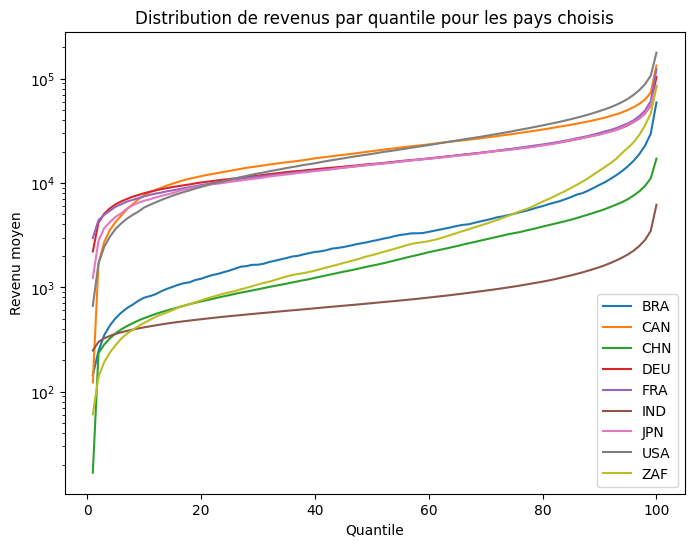

In [112]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='quantile', y='income', hue='country', data=incomesSelected)
plt.yscale('log')
plt.xlabel('Quantile')
plt.ylabel('Revenu moyen')
plt.title('Distribution de revenus par quantile pour les pays choisis')
plt.legend()
plt.show()

In [120]:
incomeFrench = incomes.loc[incomes.country == 'FRA', ['income', 'quantile','country','nation']]
incomeFrench

,income,quantile,country,nation
3300,2958.3040,1,FRA,France
3301,4412.6753,2,FRA,France
3302,4939.6350,3,FRA,France
3303,5422.9165,4,FRA,France
3304,5906.5376,5,FRA,France
...,...,...,...,...
3395,39873.5100,96,FRA,France
3396,43693.0350,97,FRA,France
3397,49489.5820,98,FRA,France
3398,60758.6130,99,FRA,France


Text(0, 0.5, 'revenus en $')

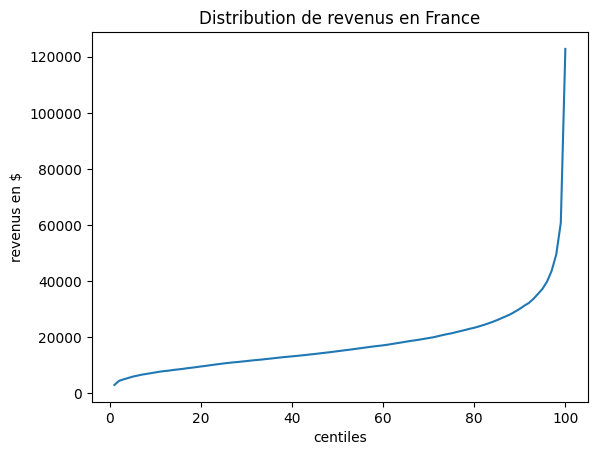

In [118]:
plt.plot(incomeFrench['quantile'], incomeFrench['income'])
plt.title('Distribution de revenus en France')
plt.xlabel('centiles')
plt.ylabel('revenus en $')

# Mission 3